# Burster Cell (Izhikevich p307) - Segregated Pipeline

In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

random_seed = 42
num_slices = 10
experiment_folder = f"output/burster_seg_filtered_sl-{num_slices}/{random_seed}"
target_folder = experiment_folder + "/target"

# module 1 is for spiking, final is a refinement of all previous modules (except passive props)
module_1_folder = experiment_folder + "/module_1"
module_final_folder = experiment_folder + "/module_final"

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_seg",
    cell_name="Burster_Izh",
    g_names = ["gbar_na3", "gbar_nap","gkdrbar_kdr","gmbar_im", "glbar_leak"]
)

sim_par= SimParams(
            h_v_init=-65.0,  # Consistent with nrngui settings
            h_tstop=500,     # Simulation time in ms
            h_dt=0.1,      # Time step in ms
            h_celsius=6.3,   # Temperature in degrees Celsius
            CI_type="constant",
            CI_amps=[0.1,0.2,0.3],   # Current injection amplitude
            CI_dur=300,      # Duration of current injection
            CI_delay=100,     # Delay before current injection
            set_g_to=[]
        )

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


# Generate Synthetic Data

In [2]:
sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/target/synthetic_0.1_0.2_0.3_


In [3]:
passive_sim_par = SimParams(
            h_v_init = -65,
            h_tstop = 1500,
            h_dt = 0.001,
            h_celsius = 6.3,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 1000,
            CI_delay = 500,
            set_g_to=[]
        )

sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name=target_folder,
        cell= target_cell,
        sim_params= passive_sim_par,
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: []
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/target/synthetic_-0.1_


# Get Passive Properties

In [4]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Spiker/seg/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Spiker/seg",
    cell_name="Simple_Spiker_seg",
    g_names = ["gnabar_hh_seg", "gkbar_hh_seg", "gl_hh_seg"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=passive_sim_par,
    trace_filepath=f"{target_folder}/passive_data.csv",
    leak_conductance_variable="gl_hh_seg",
    leak_reversal_variable="el_hh_seg"
)

In [5]:
passive_mod.set_passive_properties()
print(train_cell.passive_properties)

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.
PassiveProperties(V_rest=-65.0, R_in=191.9980291996248, tau=2.575, Cm=1.2078552500011506, g_bar_leak=0.00046907000000044683, cell_area=1.1103645074847766e-05, leak_conductance_variable='gl_hh_seg', leak_reversal_variable='el_hh_seg')


## Run Module 1

In [6]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_1_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", low=0.06, high=0.18, n_slices=num_slices),
                OptimizationParam(param="gkbar_hh_seg", low=0.018, high=0.054, n_slices=num_slices),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
            prediction_eval_method='fi_curve',
            spike_threshold=0,
            saturation_threshold=-65,
            first_n_spikes=20,
            random_state=random_seed,
            save_file=f"{module_1_folder}/results/saved_metrics.json"
        )
    )
)

In [7]:
predicted_g_data_file = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 300
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/module_1/train
FILTERING DATA
Dropping 113 traces where: All values in the window (3100:4000) are saturated (above -65 mV).
Dropping 0 traces where: No spikes are in the voltage trace.
Dataset size after filtering: 187. Saving to /home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/module_1/train/filtered_out.npy
TRAINING RANDOM FOREST REGRESSOR
Training Random Forest on Filtered Data
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'Min Spik

In [8]:
mod.pickle_rf(mod.rf_model,f"{module_1_folder}/trained_rf.pkl")

## Run Fine Tuning Module

In [9]:
from act.ACTModule import ACTModule
from act.act_types import OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters

bounds_variation = 0.15


final_mod = ACTModule(
    ModuleParameters(
        module_folder_name=module_final_folder,
        cell= train_cell,
        target_traces_file = f"{target_folder}/target_data.csv",
        sim_params= sim_par,
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gnabar_hh_seg", prediction=train_cell.predicted_g["gnabar_hh_seg"],bounds_variation=train_cell.predicted_g["gnabar_hh_seg"] * bounds_variation, n_slices=num_slices),
                OptimizationParam(param="gkbar_hh_seg", prediction=train_cell.predicted_g["gkbar_hh_seg"], bounds_variation=train_cell.predicted_g["gkbar_hh_seg"] * bounds_variation, n_slices=num_slices),
                OptimizationParam(param="gl_hh_seg", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ],
            filtered_out_features = ["no_spikes", "saturated"],
            train_features=["i_trace_stats", "number_of_spikes", "spike_times", "spike_height_stats", "number_of_troughs", "trough_times", "trough_height_stats"],
            spike_threshold=0,
            saturation_threshold=-65,
            first_n_spikes=20,
            prediction_eval_method='fi_curve',
            random_state=random_seed,
            save_file=f"{module_final_folder}/results/saved_metrics.json"
        )
    )
)

In [10]:
final_predicted_g_data_file = final_mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 300
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/module_final/train
FILTERING DATA
Dropping 44 traces where: All values in the window (3100:4000) are saturated (above -65 mV).
Dropping 0 traces where: No spikes are in the voltage trace.
Dataset size after filtering: 256. Saving to /home/mwsrgf/proj/ACT/output/spiker_seg_filtered_sl-10/46/module_final/train/filtered_out.npy
TRAINING RANDOM FOREST REGRESSOR
Training Random Forest on Filtered Data
Extracting features: ['I_mean', 'I_stdev', 'Num Spikes', 'Spike Time 1', 'Spike Time 2', 'Spike Time 3', 'Spike Time 4', 'Spike Time 5', 'Spike Time 6', 'Spike Time 7', 'Spike Time 8', 'Spike Time 9', 'Spike Time 10', 'Spike Time 11', 'Spike Time 12', 'Spike Time 13', 'Spike Time 14', 'Spike Time 15', 'Spike Time 16', 'Spike Time 17', 'Spike Time 18', 'Spike Time 19', 'Spike Time 20', 'M

In [11]:
final_mod.pickle_rf(final_mod.rf_model,f"{module_final_folder}/trained_rf.pkl")

# Results & Metrics

In [12]:
from act import ACTPlot
ACTPlot.plot_v_comparison(
    final_predicted_g_data_file, 
    module_final_folder, 
    sim_par["CI_amps"],
    sim_par["h_dt"]
    )

ACTPlot.plot_fi_comparison(
    module_final_folder, 
    sim_par["CI_amps"]
    )

In [13]:
from act.Metrics import Metrics

metrics = Metrics()

mean, stdev = metrics.print_interspike_interval_comparison(
    module_final_folder,
    final_predicted_g_data_file,
    sim_par["CI_amps"], 
    sim_par["h_dt"],
    first_n_spikes=5,
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

metrics.print_prediction_g_mae(
    actual_g={'gnabar_hh_seg': 0.12, 'gkbar_hh_seg': 0.036, 'gl_hh_seg': 0.00046907},
    save_file=f"{module_final_folder}/results/saved_metrics.json"
)

Interspike times (Target): [[12.4 12.  11.9 12. ]
 [11.1 10.7 10.6 10.7]
 [10.5 10.   9.9 10. ]]
Interspike times (Prediction): [[12.3 12.  12.  12. ]
 [11.1 10.7 10.7 10.7]
 [10.5 10.   9.9 10. ]]
MAE for each I injection: [0.04999999999999716, 0.02499999999999858, 0.0]
Mean interspike-interval MAE: 0.02499999999999858
Standard Deviation interspike-interval MAE: 0.02041241452319199
MAE of final g prediction: 0.0005245564444456141


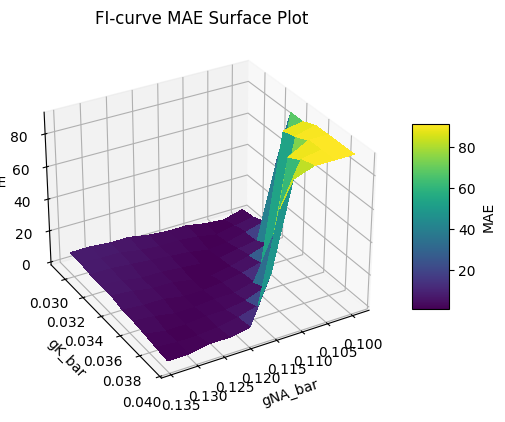

In [14]:
from act import ACTPlot as actplt

actplt.plot_training_fi_mae_surface_spiker_cell(
module_final_folder,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
f"{module_final_folder}/results/FI_MAE_Surface.html",
)

Smallest MAE values (gNa, gK, MAE): 
[[0.110884   0.031405   0.        ]
 [0.11477467 0.033689   0.        ]
 [0.10699333 0.030263   0.        ]
 [0.10310267 0.029121   0.        ]
 [0.134228   0.039399   1.11111111]
 [0.11477467 0.032547   1.11111111]]


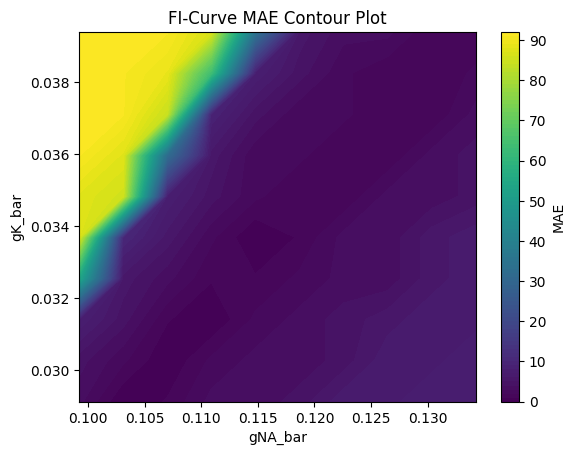

In [15]:

from act import ACTPlot as actplt

actplt.plot_training_fi_mae_contour_plot(
module_final_folder,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
num_levels=100,
results_filename=f"{module_final_folder}/results/Fi_MAE_Contour_Plot.png"
)

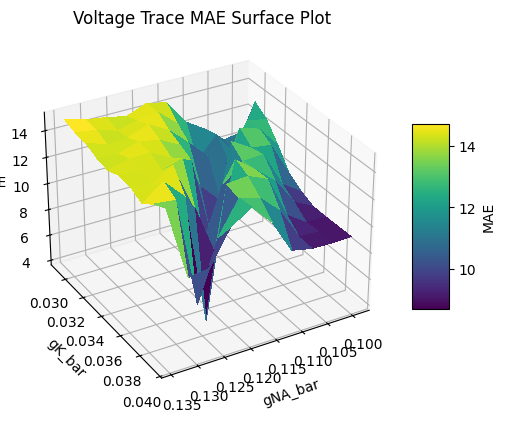

In [16]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_surface_spiker_cell(
module_final_folder,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
f"{module_final_folder}/results/V_Trace_MAE_Surface.html",
)

Smallest MAE values (gNa, gK, MAE): 
[[0.122556   0.037115   3.86256499]
 [0.12644667 0.038257   6.43510145]
 [0.11477467 0.033689   6.78723556]
 [0.11866533 0.034831   7.72742625]
 [0.11866533 0.035973   7.7477731 ]
 [0.110884   0.032547   8.54870396]]


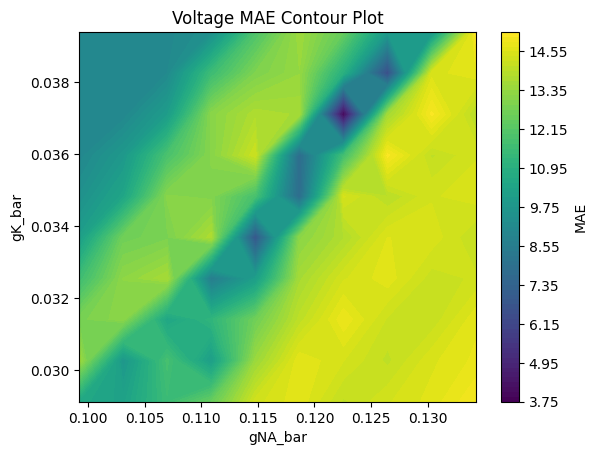

In [17]:
from act import ACTPlot as actplt

actplt.plot_training_v_mae_contour_plot(
module_final_folder,
sim_par["CI_amps"],
sim_par["CI_dur"],
sim_par["CI_delay"],
sim_par["h_dt"],
num_levels=100,
results_filename=f"{module_final_folder}/results/V_Trace_Contour_Plot.png"
)